In [1]:
import sys
sys.path.append('/home/ivan/distribution_connector')
import os

from sklearn.decomposition import TruncatedSVD


In [2]:
from sklearn import datasets
import numpy as np
import torch
from tqdm import tqdm
from connector_utils import test_models, gather_statistics, test_func
import matplotlib.pyplot as plt

In [3]:
from connector import Connector
# from one_layer_utils import samples, make_dataset, get_model, get_b
from utils import test_model
from tqdm import tqdm

In [70]:
import models
architecture = getattr(models, "Linear3NoBias") #LinearOneLayer LogRegression

import data
loaders, num_classes = data.loaders(
    "CIFAR10",
    "data",
    1024,
    1,
    "VGG",
    True,
    train_random=False,
    shuffle_train=False)

model1 = architecture.base(num_classes=10, **architecture.kwargs)
model2 = architecture.base(num_classes=10, **architecture.kwargs)

model1.load_state_dict(torch.load('curves/Linear3NoBias/curve3/checkpoint-400.pt')['model_state'])
model2.load_state_dict(torch.load('curves/Linear3NoBias/curve4/checkpoint-400.pt')['model_state'])


Files already downloaded and verified
You are going to run models on the test set. Are you sure?
Files already downloaded and verified


IncompatibleKeys(missing_keys=[], unexpected_keys=[])

In [71]:
# model1.cuda()
# model2.cuda()
# stat = {'train': [], 'test': []}
# for i in tqdm(range(3, 11)):
#     model1.load_state_dict(torch.load('curves/Linear3NoBias/curve'+str(i)+'/checkpoint-400.pt')['model_state'])
#     res = test_model(model1, loaders, cuda=True)
#     stat['train'].append(res[0]['accuracy'])
#     stat['test'].append(res[1]['accuracy'])


In [72]:
# np.array(stat['train']).std(), np.array(stat['test']).std()

In [73]:
# model1.cuda();
# model1.eval();
# test_model(model1, loaders, cuda=True)

In [74]:
# model2.cuda();
# model2.eval();
# test_model(model2, loaders, cuda=True)

In [75]:
def get_data(data_type='train'):

    layer = 0
    model1.cuda()
    model1.eval()
    functions = []
    targ = []
    data = []
    for X, y in loaders[data_type]:
        data.append(X.view(-1,3*32*32).cpu().data.numpy())
        functions.append(model1(X.cuda(), N=layer))
        targ.append(y)


    print('l', functions[0].shape)
    data = np.concatenate(data)
    targ = np.concatenate(targ)
    funcs = np.concatenate([p.cpu().data.numpy() for p in functions])
    
    return data, targ, funcs

In [76]:
data, targ, _ = get_data(data_type='train')

l torch.Size([1024, 6144])


In [77]:
data.shape, targ.shape

((50000, 3072), (50000,))

In [78]:
data_test, targ_test, _ = get_data(data_type='test')

l torch.Size([1024, 6144])


In [79]:
# data, targ = data[:6144], targ[:6144]

In [80]:
# W10 = list(model1.parameters())[0].data.cpu().numpy()
# W20 = list(model2.parameters())[0].data.cpu().numpy()

# W11 = list(model1.parameters())[-2].data.cpu().numpy()
# W21 = list(model2.parameters())[-2].data.cpu().numpy()

# W12 = list(model1.parameters())[-1].data.cpu().numpy()
# W22 = list(model2.parameters())[-1].data.cpu().numpy()

In [81]:
def next_layer(W, data):
    funcs = np.maximum(data @ W.T, 0)
    return funcs

    
def accuracy(pred, targ):
    ens_acc = 100.0 * np.mean(np.argmax(pred, axis=1) == targ)
    return ens_acc

In [82]:
# data = data[:2000]
# targ = targ[:2000]

In [83]:
# pred = W12 @ np.maximum(W11 @ np.maximum(W10 @ data.T, 0), 0)
# pred_test = W12 @ np.maximum(W11 @ np.maximum(W10 @ data_test.T, 0), 0)
# print(accuracy(pred.T, targ), accuracy(pred_test.T, targ_test))

In [84]:
# pred = W22 @ np.maximum(W21 @ np.maximum(W20 @ data.T, 0), 0)
# pred_test = W22 @ np.maximum(W21 @ np.maximum(W20 @ data_test.T, 0), 0)
# print(accuracy(pred.T, targ), accuracy(pred_test.T, targ_test))

In [85]:
# funcs1 = next_layer(W10, data=data)
# funcs2  = next_layer(W20, data=data)

In [86]:
# f_inv2 = np.linalg.pinv(funcs2.T)
# W11b2 = W11 @ funcs1.T @ f_inv2

In [87]:
# pred = W12 @ np.maximum(W11b2 @ np.maximum(W20 @ data.T, 0), 0)
# pred_test = W12 @ np.maximum(W11b2 @ np.maximum(W20 @ data_test.T, 0), 0)
# print(accuracy(pred.T, targ), accuracy(pred_test.T, targ_test))

In [88]:
# funcs12 = next_layer(W11, data=funcs1)
# funcs22  = next_layer(W21, data=funcs2)

In [89]:
# f_inv22 = np.linalg.pinv(funcs22.T)
# W12b2 = W12 @ funcs12.T @ f_inv22

In [90]:
# pred = W12 @ np.maximum(W11b2 @ np.maximum(W20 @ data.T, 0), 0)
# pred_test = W12b2 @ np.maximum(W21 @ np.maximum(W20 @ data_test.T, 0), 0)
# print(accuracy(pred.T, targ), accuracy(pred_test.T, targ_test))

In [91]:
# print(W10.shape, W11.shape, W12.shape)

In [92]:
class PointFinder():
    def __init__(self, model1, model2):
        out = {}
        self.W10 = list(model1.parameters())[0].data.cpu().numpy()
        self.W20 = list(model2.parameters())[0].data.cpu().numpy()

        self.W11 = list(model1.parameters())[-2].data.cpu().numpy()
        self.W21 = list(model2.parameters())[-2].data.cpu().numpy()

        self.W12 = list(model1.parameters())[-1].data.cpu().numpy()
        self.W22 = list(model2.parameters())[-1].data.cpu().numpy()

        self.funcs1 = next_layer(self.W10, data=data)
        self.funcs2  = next_layer(self.W20, data=data)
        self.f_inv2 = np.linalg.pinv(self.funcs2.T)
        self.W11b2 = self.W11 @ self.funcs1.T @ self.f_inv2

    def find_point(self, t=0.5, method='arc_connect'):

        out = {}
        if 0<=t<1:
            s = t
            # go from model1 basic to model2 basis weight in 2th layer
            Wn0 = getattr(Connector(self.W10, self.W20), method)(t=s)[1]
            Wn1 = getattr(Connector(self.W11.T, self.W11b2.T), method)(t=s)[1].T
            
            pred = self.W12 @ np.maximum( Wn1 @ np.maximum(Wn0 @ data.T, 0), 0)
            out['train'] = accuracy(pred.T, targ)

            pred_test = self.W12 @ np.maximum( Wn1 @ np.maximum(Wn0 @ data_test.T, 0), 0)
            out['test'] = accuracy(pred_test.T, targ_test)
        elif 1<=t<=2:
            s = t - 1
            # go from model1 basic to model2 basis weight in 3th layer
            Wn1 = getattr(Connector(self.W11b2, self.W21), method)(t=s)[1]
            Wn2 = getattr(Connector(self.W12.T, self.W22.T), method)(t=s)[1].T
            
            pred = Wn2 @ np.maximum( Wn1 @ np.maximum(self.W20 @ data.T, 0), 0)
            out['train'] = accuracy(pred.T, targ)

            pred_test = Wn2 @ np.maximum( Wn1 @ np.maximum(self.W20 @ data_test.T, 0), 0)
            out['test'] = accuracy(pred_test.T, targ_test)
  
        else:
            assert not  0<=t<=2, 't is not in [0, 2]'

        return out

In [113]:
class PointFinderInverse():
    def __init__(self, model1, model2):
        out = {}
        self.W10 = list(model1.parameters())[0].data.cpu().numpy()
        self.W20 = list(model2.parameters())[0].data.cpu().numpy()

        self.W11 = list(model1.parameters())[-2].data.cpu().numpy()
        self.W21 = list(model2.parameters())[-2].data.cpu().numpy()

        self.W12 = list(model1.parameters())[-1].data.cpu().numpy()
        self.W22 = list(model2.parameters())[-1].data.cpu().numpy()

        self.funcs11 = next_layer(self.W10, data=data)
        self.funcs12 = next_layer(self.W11, data=self.funcs11)
        
        self.funcs21 = next_layer(self.W20, data=data)
        self.funcs22 = next_layer(self.W21, data=self.funcs21)
        
        self.f_inv21 = np.linalg.pinv(self.funcs21.T)
        self.W11b2 = self.W11 @ self.funcs11.T @ self.f_inv21
        
        self.f_inv22 = np.linalg.pinv(self.funcs22.T)
        self.W12b2 = self.W12 @ self.funcs12.T @ self.f_inv22
        
    def get_weights(self, t, method='arc_connect'):
        if 0<=t<=1:
            s = t
            # go from model1 basic to model2 basis weight in 2th layer
            
            Wn0 = getattr(Connector(self.W10, self.W20), method)(t=s)[1]
            
            funcs = next_layer(Wn0, data=data)
            f_inv = np.linalg.pinv(funcs.T)
            Wn1 = self.W11 @ self.funcs11.T @ f_inv
            
            return self.W12, Wn1, Wn0
        elif 1<t<=2:
            s = t - 1
            # go from model1 basic to model2 basis weight in 3th layer
            Wn1 = getattr(Connector(self.W11b2, self.W21), method)(t=s)[1]
#             Wn1 = getattr(Connector(self.W11b2.T, self.W21.T), method)(t=s)[1].T

            funcs = next_layer(Wn1, data=self.funcs21)
            f_inv = np.linalg.pinv(funcs.T)
            Wn2 = self.W12 @ self.funcs12.T @ f_inv
            
            return Wn2, Wn1, self.W20
        elif 2<t<=3:
            s = t - 2
            Wn1 = getattr(Connector(self.W12b2, self.W22), method)(t=s)[1]
            
            return Wn1, self.W21, self.W20
            
        
    def find_point(self, t=0.5, method='arc_connect'):

        out = {}
        if 0<=t<=1:
            s = t
            # go from model1 basic to model2 basis weight in 2th layer
            
            Wn0 = getattr(Connector(self.W10, self.W20), method)(t=s)[1]
#             Wn0 = getattr(Connector(self.W10.T, self.W20.T), method)(t=s)[1].T
            
            funcs = next_layer(Wn0, data=data)
            f_inv = np.linalg.pinv(funcs.T)
            Wn1 = self.W11 @ self.funcs11.T @ f_inv
            
            pred = self.W12 @ np.maximum( Wn1 @ np.maximum(Wn0 @ data.T, 0), 0)
            out['train'] = accuracy(pred.T, targ)

            pred_test = self.W12 @ np.maximum( Wn1 @ np.maximum(Wn0 @ data_test.T, 0), 0)
            out['test'] = accuracy(pred_test.T, targ_test)

        elif 1<t<=2:
            s = t - 1
            # go from model1 basic to model2 basis weight in 3th layer
            Wn1 = getattr(Connector(self.W11b2, self.W21), method)(t=s)[1]
#             Wn1 = getattr(Connector(self.W11b2.T, self.W21.T), method)(t=s)[1].T

            funcs = next_layer(Wn1, data=self.funcs21)
            f_inv = np.linalg.pinv(funcs.T)
            Wn2 = self.W12 @ self.funcs12.T @ f_inv

            pred = Wn2 @ np.maximum( Wn1 @ np.maximum(self.W20 @ data.T, 0), 0)
            out['train'] = accuracy(pred.T, targ)

            pred_test = Wn2 @ np.maximum( Wn1 @ np.maximum(self.W20 @ data_test.T, 0), 0)
            out['test'] = accuracy(pred_test.T, targ_test)
            
        elif 2<t<=3:
            s = t - 2
            Wn1 = getattr(Connector(self.W12b2, self.W22), method)(t=s)[1]
#             Wn1 = getattr(Connector(self.W12b2.T, self.W22.T), method)(t=s)[1].T
               
            pred = Wn1 @ np.maximum( self.W21 @ np.maximum(self.W20 @ data.T, 0), 0)
            out['train'] = accuracy(pred.T, targ)

            pred_test = Wn1 @ np.maximum( self.W21 @ np.maximum(self.W20 @ data_test.T, 0), 0)
            out['test'] = accuracy(pred_test.T, targ_test)
            
        else:
            assert not  0<=t<=3, 't is not in [0, 3]'
            
        print(t, out)

        return out

# Path Visualization 

In [114]:
finder = PointFinderInverse(model1, model2) 
# finder = PointFinder(model1, model2)

In [124]:
Weghts1 = finder.get_weights(t=1.5)
Weghts2 = finder.get_weights(t=1.7)
Comb = []
for W1, W2 in zip(Weghts1, Weghts2):
    Comb.append((W1+W2)/2)

In [125]:
pred = Comb[0] @ np.maximum( Comb[1] @ np.maximum(Comb[2] @ data.T, 0), 0)
accuracy(pred.T, targ)

72.798

In [126]:
pred = Comb[0] @ np.maximum( Comb[1] @ np.maximum(Comb[2] @ data_test.T, 0), 0)
accuracy(pred.T, targ_test)

59.589999999999996

In [127]:
point = finder.find_point(t=1.5, method='arc_connect')

1.5 {'train': 71.096, 'test': 59.47}


In [128]:
point = finder.find_point(t=1.7, method='arc_connect')

1.7 {'train': 78.00399999999999, 'test': 60.45}


In [120]:
point3 = finder.find_point(t=1.5, method='arc_connect')
point3

1.5 {'train': 71.096, 'test': 59.47}


{'train': 71.096, 'test': 59.47}

In [97]:
point

{'train': 95.12, 'test': 62.53999999999999}

In [98]:
point1 = finder.find_point(t=1, method='arc_connect')
point1

1 {'train': 93.44, 'test': 61.88}


{'train': 93.44, 'test': 61.88}

In [99]:
point2 = finder.find_point(t=2, method='arc_connect')
point2

2 {'train': 89.832, 'test': 63.53}


{'train': 89.832, 'test': 63.53}

In [100]:
time = np.linspace(0, 2, 9)

In [101]:
time = list(time) + [2.5, 3] 

In [102]:
time

[0.0, 0.25, 0.5, 0.75, 1.0, 1.25, 1.5, 1.75, 2.0, 2.5, 3]

In [103]:
point

{'train': 95.12, 'test': 62.53999999999999}

In [104]:
path = {'test': [], 'train': []}
for t in tqdm(time):
    point = finder.find_point(t=t, method='arc_connect')
    path['test'].append(100-point['test']) 
    path['train'].append(100-point['train']) 

  9%|▉         | 1/11 [01:57<19:35, 117.60s/it]

0.0 {'train': 95.12, 'test': 62.53999999999999}


 18%|█▊        | 2/11 [03:55<17:38, 117.59s/it]

0.25 {'train': 94.472, 'test': 62.22}


 27%|██▋       | 3/11 [05:52<15:40, 117.56s/it]

0.5 {'train': 93.518, 'test': 61.980000000000004}


 36%|███▋      | 4/11 [07:50<13:42, 117.55s/it]

0.75 {'train': 93.268, 'test': 61.9}


 45%|████▌     | 5/11 [09:47<11:45, 117.57s/it]

1.0 {'train': 93.44, 'test': 61.88}


 55%|█████▍    | 6/11 [10:07<07:21, 88.22s/it] 

1.25 {'train': 82.502, 'test': 60.370000000000005}


 64%|██████▎   | 7/11 [10:27<04:30, 67.67s/it]

1.5 {'train': 69.112, 'test': 57.620000000000005}


 73%|███████▎  | 8/11 [10:47<02:39, 53.30s/it]

1.75 {'train': 80.172, 'test': 60.6}


 82%|████████▏ | 9/11 [11:06<01:26, 43.24s/it]

2.0 {'train': 89.832, 'test': 63.53}


 91%|█████████ | 10/11 [11:14<00:32, 32.50s/it]

2.5 {'train': 93.88, 'test': 63.970000000000006}


100%|██████████| 11/11 [11:21<00:00, 24.97s/it]

3 {'train': 95.27799999999999, 'test': 63.44}


In [109]:
100 - np.array(path['train'])

array([95.12 , 94.472, 93.518, 93.268, 93.44 , 82.502, 69.112, 80.172,
       89.832, 93.88 , 95.278])

In [110]:
100 - np.array(path['test'])

array([62.54, 62.22, 61.98, 61.9 , 61.88, 60.37, 57.62, 60.6 , 63.53,
       63.97, 63.44])

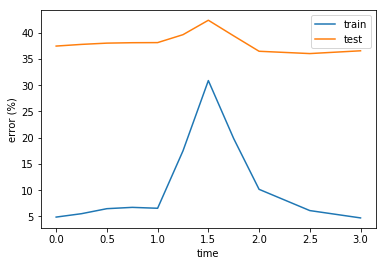

In [111]:
plt.plot(time, path['train'], label='train')
plt.plot(time, path['test'], label='test') 
plt.legend()
plt.xlabel('time')
plt.ylabel('error (%)')
plt.show()

In [108]:
path_l = {'test': [], 'train': []}
for t in tqdm(time):
    point = finder.find_point(t=t, method='lin_connect')
    path_l['test'].append(100-point['test']) 
    path_l['train'].append(100-point['train']) 

  0%|          | 0/11 [00:00<?, ?it/s]

KeyboardInterrupt: 

In [ ]:
plt.plot(time, path_l['train'], label='train')
plt.plot(time, path_l['test'], label='test') 
plt.legend()
plt.xlabel('time')
plt.ylabel('error (%)')
plt.show()

# Count statistic in the fixed point

In [ ]:
def get_stat(pointfinder, t=1.5, method='arc_connect'):
    stat = {'test': [], 'train': []}
    for i in tqdm(range(3, 9)):
        model1.load_state_dict(torch.load('curves/Linear3NoBias/curve'+str(i)+'/checkpoint-400.pt')['model_state'])
        model2.load_state_dict(torch.load('curves/Linear3NoBias/curve'+str(i+1)+'/checkpoint-400.pt')['model_state'])
        finder = pointfinder(model1, model2) 
        point = finder.find_point(t=t, method=method)
        stat['test'].append(point['test']) 
        stat['train'].append(point['train']) 
    return stat

In [ ]:
# arcbutterfly = get_stat(PointFinder, t=1.5, method='arc_connect')

In [ ]:
# arcbutterfly

In [ ]:
def get_mean_svd(stat):
    train = np.array(stat['train'])
    test = np.array(stat['test'])
    return train.mean(), train.std(), test.mean(), test.std()

In [ ]:
# get_mean_svd(arcbutterfly)

In [ ]:
# linbutterfly = get_stat(PointFinder, t=1.5, method='lin_connect')

In [ ]:
# linbutterfly

In [ ]:
# get_mean_svd(linbutterfly)

In [ ]:
linpseudo = get_stat(PointFinderInverse, t=1.5, method='lin_connect')

In [ ]:
linpseudo

In [ ]:
get_mean_svd(linpseudo)

In [ ]:
arcpseudo = get_stat(PointFinderInverse, t=1.5, method='arc_connect')

In [ ]:
arcpseudo

In [ ]:
get_mean_svd(arcpseudo)

In [59]:
f_inv1 = np.linalg.pinv(funcs1.T)

In [60]:
f_inv2 = np.linalg.pinv(funcs2.T)

In [62]:
pred = W12 @ np.maximum(W11 @ np.maximum(W10 @ data.T, 0), 0)
accuracy(pred.T, targ)

95.27799999999999

In [70]:
pred = W12 @ np.maximum(W11 @ np.maximum(W10 @ data.T, 0), 0)
accuracy(pred.T, targ)

95.27799999999999

In [64]:
t=0.5
pred = Connector(W12.T, W22.T).arc_connect(t=t)[1].T @ np.maximum(Connector(W11, (W21 @ funcs2.T @ f_inv1)).arc_connect(t=t)[1] @  np.maximum(W10 @ data.T, 0), 0)
accuracy(pred.T, targ)

61.07

In [65]:
t = 0.5
pred = W22 @ np.maximum(Connector((W21 @ funcs2.T @ f_inv1).T, W21.T).arc_connect(t=t)[1].T @ np.maximum(Connector(W10, W20).arc_connect(t=t)[1]  @ data.T, 0), 0)
accuracy(pred.T, targ)

78.448